In [1]:
import torchvision
import torchvision.transforms as transforms
import os
import yaml
import matplotlib.pyplot as plt
import numpy as np

/home/coartix/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_hip.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
os.chdir('../')
from DataAugmentation import DataAugmentation
from utils import Config

In [3]:

with open("configs/cifar10_base.yml") as f:
        yml_dict = yaml.load(f, Loader=yaml.FullLoader)
config = Config(yml_dict)

In [4]:
data_aug = DataAugmentation(
    config.img_size,
    config.global_crop_ratio,
    config.local_crop_ratio,
    config.nb_local_crops,
    config.dataset_means,
    config.dataset_stds
)

dataset_original = torchvision.datasets.CIFAR10(
    root=config.original_dataset_path,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

dataset_transformed = torchvision.datasets.CIFAR10(
    root=config.test_dataset_path,
    train=False,
    transform=data_aug,
    download=True
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def imshow(imgs):
    def rescale_img(image):
        image = image - image.min()
        image = image / image.max()
        return image

    if isinstance(imgs, list):
        print("Global views:")
        fig, axs = plt.subplots(1, min(len(imgs), 2), figsize=(10, 5))
        for i in range(2):
            npimg = rescale_img(imgs[i].numpy())
            axs[i].imshow(np.transpose(npimg, (1, 2, 0)))
            axs[i].axis('off')
        plt.show()

        print("Local views:")
        if len(imgs) > 2:
            fig, axs = plt.subplots(1, len(imgs) - 2, figsize=(15, 5))
            for i in range(2, len(imgs)):
                npimg = rescale_img(imgs[i].numpy())
                axs[i - 2].imshow(np.transpose(npimg, (1, 2, 0)))
                axs[i - 2].axis('off')
            plt.show()
    else:
        npimg = rescale_img(imgs.numpy())
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')
        plt.show()

Original Image:


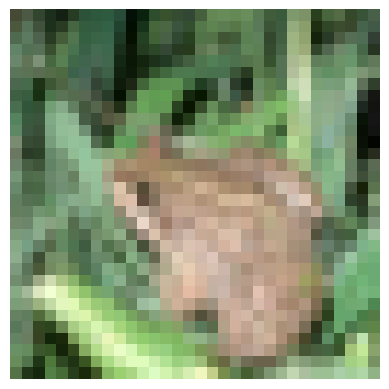

Global views:


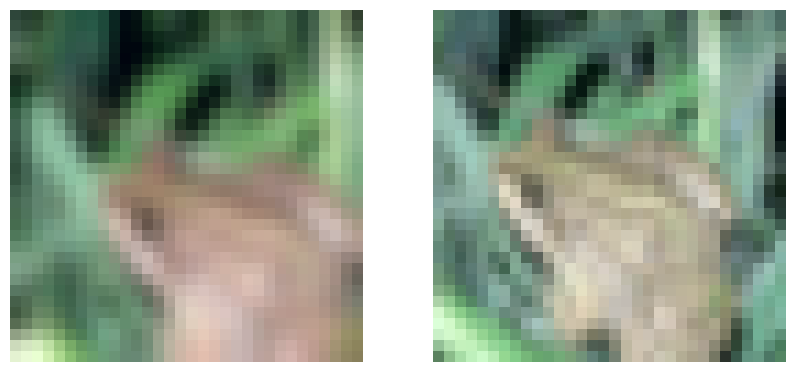

Local views:


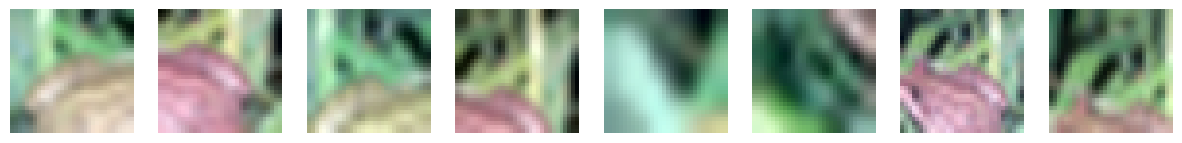

In [6]:
img_original, _ = dataset_original[4]
img_transformed, _ = dataset_transformed[4]

print("Original Image:")
imshow(img_original)

imshow(img_transformed)

### Testing ViT on classification task

In [7]:
from models.ViT import vit_tiny
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [8]:
clf_model = vit_tiny(patch_size=4, embed_dim=192, depth=6, num_classes=10, img_size=[32],
  drop_rate=0.2, attn_drop_rate=0.2, drop_layer_rate=0.2, num_heads=6)
clf_model.cuda()

ViT_small(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
  )
  (pos_drop): Dropout(p=0.2, inplace=False)
  (blocks): ModuleList(
    (0-4): 5 x Block(
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (q): Linear(in_features=192, out_features=192, bias=True)
        (k): Linear(in_features=192, out_features=192, bias=True)
        (v): Linear(in_features=192, out_features=192, bias=True)
        (attn_drop): Dropout(p=0.2, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (drop_

Creating dataloader

In [9]:
train_size = int(0.8 * len(dataset_original))
test_size = len(dataset_original) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset_original, [train_size, test_size])

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False
)

Simple training

In [10]:
epochs = 20
optimizer = optim.Adam(clf_model.parameters())
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    print("Epoch:", epoch)
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, label = data
        inputs, label = inputs.cuda(), label.cuda()
        output = clf_model(inputs)

        optimizer.zero_grad()
        loss = F.cross_entropy(output, label)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        if i % 25 == 24:
            print("Loss:", running_loss / 25)
            running_loss = 0.0

print("Finished Training")

Epoch: 0
Loss: 2.3374989318847654
Loss: 2.2098891067504884
Epoch: 1
Loss: 2.07273380279541
Loss: 2.023993773460388
Epoch: 2
Loss: 1.9996145582199096
Loss: 1.9562778329849244
Epoch: 3
Loss: 1.8800020980834962
Loss: 1.8756900310516358
Epoch: 4
Loss: 1.8375945138931273
Loss: 1.8354284763336182
Epoch: 5
Loss: 1.7864804410934447
Loss: 1.7664946842193603
Epoch: 6
Loss: 1.7282678127288817
Loss: 1.7493727731704711
Epoch: 7
Loss: 1.7188204765319823
Loss: 1.7078668069839478
Epoch: 8
Loss: 1.7121116733551025
Loss: 1.6915915250778197
Epoch: 9
Loss: 1.623285026550293
Loss: 1.616668906211853
Epoch: 10
Loss: 1.6138884401321412
Loss: 1.6347296905517579
Epoch: 11
Loss: 1.6211479091644287
Loss: 1.6031730937957764
Epoch: 12
Loss: 1.5834078550338746
Loss: 1.5594773626327514
Epoch: 13
Loss: 1.5620968198776246
Loss: 1.600466046333313
Epoch: 14
Loss: 1.5398792028427124
Loss: 1.5509128761291504
Epoch: 15
Loss: 1.5348486948013305
Loss: 1.5381933212280274
Epoch: 16
Loss: 1.4647426843643188
Loss: 1.5582745027542

Testing

In [11]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_dataloader:
        input, label = data
        input, label = input.cuda(), label.cuda()
        output = clf_model(input)
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

print(f"Accuracy of the network on the test images: {100 * correct / total}%")

Accuracy of the network on the test images: 41.95%
